# TF neural net with normalized ISO spectra

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from IPython.core.debugger import set_trace as st
from sklearn.model_selection import train_test_split
from time import time

# My modules
from swsnet import helpers

print(tf.__version__)

1.12.0


## Dataset: ISO-SWS (normalized, culled)

In [2]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra_normalized/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata_step2_culled.pkl'

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

### Subset 1: all data included (trimmed)

In [3]:
features, labels = helpers.load_data(base_dir=base_dir, metadata=metadata,
                                     only_ok_data=False, clean=False, verbose=False,
                                     cut_28micron=True)

In [4]:
print(features.shape)
print(labels.shape)

(1235, 303)
(1235,)


### Subset 2: exclude group 7 (trimmed)

In [5]:
features_clean, labels_clean = \
    helpers.load_data(base_dir=base_dir, metadata=metadata,
                      only_ok_data=False, clean=True, verbose=False,
                      cut_28micron=True)

In [6]:
print(features_clean.shape)
print(labels_clean.shape)

(1058, 303)
(1058,)


### Subset 3: exclude group 7, uncertain data (trimmed)

In [13]:
features_certain, labels_certain = \
    helpers.load_data(base_dir=base_dir, metadata=metadata,
                      only_ok_data=True, clean=True, verbose=False,
                      cut_28micron=False, remove_group=6)

In [10]:
print(features_certain.shape)
print(labels_certain.shape)

(741, 359)
(741,)


In [14]:
np.unique(labels_certain)

array([0, 1, 2, 3, 4])

# Testing l2norms

In [15]:
def neural(features, labels, test_size=0.3, l2norm=0.01):

    X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, test_size=test_size, random_state = 42)

    # Sequential model, 7 classes of output.
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm), input_dim=303))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(5, activation='softmax'))

    # Early stopping condition.
    callback = [tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=0)]

    # Recompile model and fit.
    model.compile(optimizer=keras.optimizers.Adam(0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    #     model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=False)
    model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=callback, verbose=False)

    # Check accuracy.
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]
    print("L2 norm, accuracy: ", l2norm, accuracy)
    
    return model, test_size, accuracy

In [20]:
# for l2norm in (0.1, 0.01, 0.001, 0.0001, 0.00001):
#     model, test_size, accuracy = neural(features, labels, l2norm=l2norm)

L2 norm, accuracy:  0.1 0.4660194177650711
L2 norm, accuracy:  0.01 0.7313915869178895
L2 norm, accuracy:  0.001 0.7766990302835853
L2 norm, accuracy:  0.0001 0.7637540466577104
L2 norm, accuracy:  1e-05 0.7669902922266124


In [17]:
# for l2norm in (0.1, 0.01, 0.001, 0.0001, 0.00001):
#     model, test_size, accuracy = neural(features_clean, labels_clean, l2norm=l2norm)

L2 norm, accuracy:  0.1 0.48113207622144205
L2 norm, accuracy:  0.01 0.7452830199925404
L2 norm, accuracy:  0.001 0.7798742123369901
L2 norm, accuracy:  0.0001 0.7955974831521136
L2 norm, accuracy:  1e-05 0.8018867935774461


In [23]:
# for l2norm in (0.1, 0.01, 0.001, 0.0001, 0.00001):
#     model, test_size, accuracy = neural(features_certain, labels_certain, l2norm=l2norm)

L2 norm, accuracy:  0.1 0.5859375
L2 norm, accuracy:  0.01 0.828125
L2 norm, accuracy:  0.001 0.8671875
L2 norm, accuracy:  0.0001 0.89453125
L2 norm, accuracy:  1e-05 0.87890625


In [24]:
# for l2norm in (0.001, 0.0001, 0.00001, 0.000001):
#     model, test_size, accuracy = neural(features_certain, labels_certain, l2norm=l2norm)

L2 norm, accuracy:  0.001 0.88671875
L2 norm, accuracy:  0.0001 0.859375
L2 norm, accuracy:  1e-05 0.86328125
L2 norm, accuracy:  1e-06 0.859375


***

# Testing training size vs. accuracy

Model:

In [161]:
def run_NN(input_tuple):
    """Run a Keras NN for the purpose of examining the effect of training set size.
    
    Args:
        features (ndarray): Array containing the spectra (fluxes).
        labels (ndarray): Array containing the group labels for the spectra.
        test_size (float): Fraction of test size relative to (test + training).
        
    Returns:
        test_size (float): Input test_size, just a sanity check!
        accuracy (float): Accuracy of this neural net when applied to the test set.
    """
    
    features, labels, test_size = input_tuple
    l2norm = 0.001
    
    X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, test_size=test_size, random_state = 42)
    
    # Sequential model, 7 classes of output.
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm), input_dim=359))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2norm)))
    model.add(keras.layers.Dense(5, activation='softmax'))

    # Early stopping condition.
    callback = [tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=0)]

    # Recompile model and fit.
    model.compile(optimizer=keras.optimizers.Adam(0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    #     model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=False)
    model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=callback, verbose=False)

    # Check accuracy.
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]
#     print("Test size, accuracy: ", test_size, accuracy)

    return test_size, accuracy

In [162]:
def run_networks(search_map):
    # Run the networks in parallel.
    start = time()
    pool = ProcessPoolExecutor(max_workers=7)
    results = list(pool.map(run_NN, search_map))
    end = time()
    print('Took %.3f seconds' % (end - start))

    run_matrix = np.array(results)
    return run_matrix

def plot_results(run_matrix):
    # Examine results.
    plt.plot(run_matrix.T[0], run_matrix.T[1], 's', mfc='w', ms=5, mew=2, mec='r');
    plt.xlabel('Test size (fraction)');
    plt.ylabel('Test accuracy');
    plt.minorticks_on();
#     plt.xlim(left=0);  
    return

Search space (training size):

In [163]:
# Values of test_size to probe.
# search_space = np.arange(0.14, 0.60, 0.02)
search_space = np.arange(0.14, 0.60, 0.1)
print('Size of test set considered: ', search_space)

# Number of iterations for each test_size value.
# n_iterations = 20
n_iterations = 2

# Create a vector to iterate over.
rx = np.array([search_space] * n_iterations).T
search_space_full = rx.flatten()

print('Number of iterations per test_size: ', n_iterations)
print('Total number of NN iterations required: ', n_iterations * len(search_space))

Size of test set considered:  [0.14 0.24 0.34 0.44 0.54]
Number of iterations per test_size:  2
Total number of NN iterations required:  10


In [164]:
# Wrap up tuple inputs for running in parallel.
search_map = [(features, labels, x) for x in search_space_full]
search_map_clean = [(features_clean, labels_clean, x) for x in search_space_full]
search_map_certain = [(features_certain, labels_certain, x) for x in search_space_full]

In [165]:
# run_matrix = run_networks(search_map)
# run_matrix_clean = run_networks(search_map_clean)
run_matrix_certain = run_networks(search_map_certain)

Took 46.274 seconds


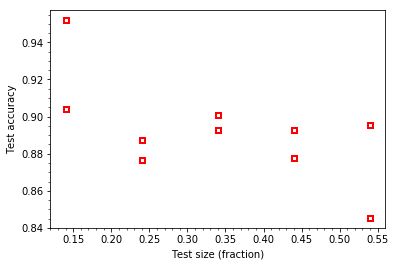

In [166]:
plot_results(run_matrix_certain)

# Results - trimmed wavelength arrays

## Full set:

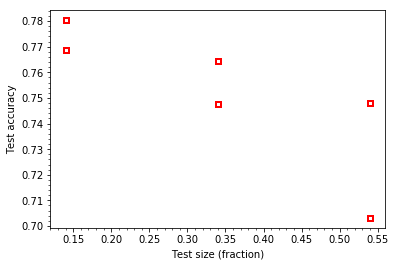

In [14]:
plot_results(run_matrix)

## Clean set:

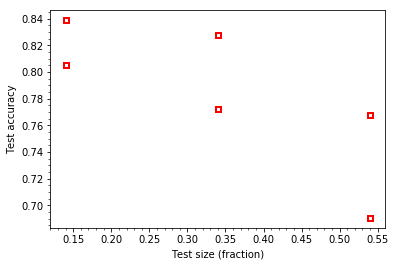

In [15]:
plot_results(run_matrix_clean)

## Certain set: (< 28 µm only)

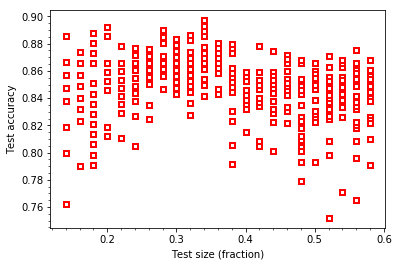

In [25]:
plot_results(run_matrix_certain)

## Certain set: (full wavelength array)

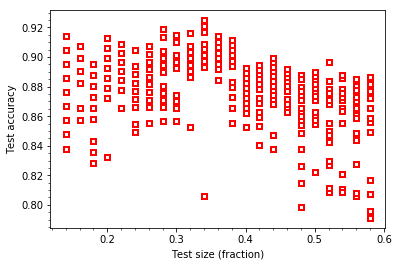

In [37]:
plot_results(run_matrix_certain)

In [45]:
x, y = run_matrix_certain.T
z = np.polyfit(x, y, 4)
p = np.poly1d(z)

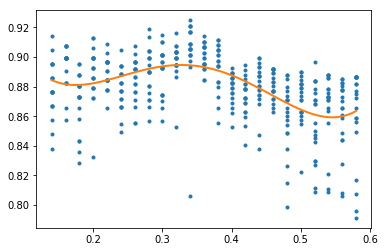

In [47]:
xp = np.linspace(x[0], x[-1], 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-', lw=2)

# Remove group 6! only six!

## Certain set: (full wavelength array)

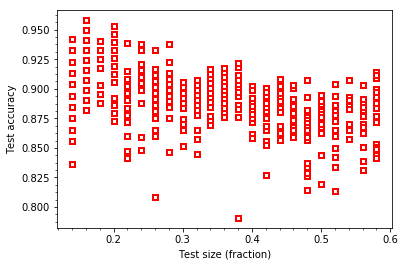

In [31]:
plot_results(run_matrix_certain)

In [32]:
x, y = run_matrix_certain.T
z = np.polyfit(x, y, 4)
p = np.poly1d(z)

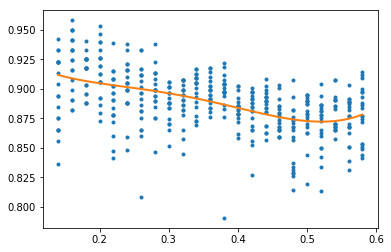

In [33]:
xp = np.linspace(x[0], x[-1], 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-', lw=2)

***

Based on the above, probably need to do more data preprocessing:
- e.g., remove untrustworthy data

In [21]:
# save_path = '../models/nn_sorted_normalized_culled.h5'

In [22]:
# model.save(save_path)